In [14]:
import matplotlib.pyplot as plt
import wfdb
import pandas as pd
import torch
from torch.utils.data import DataLoader
from lstm import lstm_model, train_lstm
from data_processing import *
from globals import DATA
from training_functions import *
from scipy import signal
from skimage.restoration import denoise_wavelet

In [15]:
get_and_save_data(dir_path=DATA)

model, train_loader, encoder_input_train, decoder_output_train, encoder_input_test, decoder_output_test = get_data_and_model(input_dim=2, hidden_dim=128, layer_dim=3, output_dim=1)

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_curve = train_lstm(model, device, train_loader, num_epochs=3, lr = 0.001)
# state = torch.load("./models/model_1.pt")
# model.load_state_dict(state)
# print(model.eval())

Epoch: 1/3, Step: 100/27788, Loss: 0.0292
Epoch: 1/3, Step: 200/27788, Loss: 0.0389
Epoch: 1/3, Step: 300/27788, Loss: 0.0305
Epoch: 1/3, Step: 400/27788, Loss: 0.0340
Epoch: 1/3, Step: 500/27788, Loss: 0.0310
Epoch: 1/3, Step: 600/27788, Loss: 0.0341
Epoch: 1/3, Step: 700/27788, Loss: 0.0331
Epoch: 1/3, Step: 800/27788, Loss: 0.0306
Epoch: 1/3, Step: 900/27788, Loss: 0.0252
Epoch: 1/3, Step: 1000/27788, Loss: 0.0262
Epoch: 1/3, Step: 1100/27788, Loss: 0.0294
Epoch: 1/3, Step: 1200/27788, Loss: 0.0258
Epoch: 1/3, Step: 1300/27788, Loss: 0.0308
Epoch: 1/3, Step: 1400/27788, Loss: 0.0301
Epoch: 1/3, Step: 1500/27788, Loss: 0.0282
Epoch: 1/3, Step: 1600/27788, Loss: 0.0274
Epoch: 1/3, Step: 1700/27788, Loss: 0.0278
Epoch: 1/3, Step: 1800/27788, Loss: 0.0261
Epoch: 1/3, Step: 1900/27788, Loss: 0.0227
Epoch: 1/3, Step: 2000/27788, Loss: 0.0274
Epoch: 1/3, Step: 2100/27788, Loss: 0.0250
Epoch: 1/3, Step: 2200/27788, Loss: 0.0232
Epoch: 1/3, Step: 2300/27788, Loss: 0.0217
Epoch: 1/3, Step: 24

In [17]:
samp = 60000
rec = wfdb.rdrecord('G:/physionet.org/files/mimic4wdb/0.1.0/waves/p109/p10952189/82439920/82439920',
                    sampfrom=0, sampto=samp,
                    smooth_frames=False)

#create an enmpy dataframe
df = pd.DataFrame()
for (name, units, data) in zip(rec.sig_name,
                               rec.units,
                               rec.e_p_signal):
    # put into a dataframe
    if len(data) == 4*samp:

        df[str(name)+'('+str(units)+')'] = data
    else:
        if name == 'Pleth':
            pleth = data
        if name == 'ABP':
            abp = data

    print('{} (units {}):'.format(name, units))
    print(len(data))

df['sum'] = -df['II(mV)']-df['aVR(mV)']

II (units mV):
240000
V (units mV):
240000
aVR (units mV):
240000
ABP (units mmHg):
120000
CVP (units mmHg):
120000
PAP (units mmHg):
120000
Pleth (units NU):
120000
Resp (units Ohm):
60000


In [18]:
def get_mimic_test_data(test_ecg, test_ppg, test_abp, timewindow=32):


    ppg_test_conv = test_ppg
    ecg_test_conv = test_ecg
    abp_test_conv = test_abp

    ppg_test_conv_scaled = (ppg_test_conv - ppg_test_conv.min())/(ppg_test_conv.max()-ppg_test_conv.min())
    ecg_test_conv_scaled = (ecg_test_conv - ecg_test_conv.min())/(ecg_test_conv.max()-ecg_test_conv.min())
    abp_test_conv_scaled = (abp_test_conv - abp_test_conv.min())/(abp_test_conv.max()-abp_test_conv.min())

    ppg_test_timeseries_scaled = convert_to_timeseries(ppg_test_conv_scaled, timewindow)
    ecg_test_timeseries_scaled = convert_to_timeseries(ecg_test_conv_scaled, timewindow)
    abp_test_timeseries_scaled = convert_to_timeseries(abp_test_conv_scaled, timewindow)

    #put ppg and ecg together to form the encoder input with shape (201554,32,2)
    encoder_input_test = np.stack((ppg_test_timeseries_scaled, ecg_test_timeseries_scaled), axis=2)

    #stack the abp as well to form the decoder output with shape (201554,32,1)
    decoder_output_test = np.expand_dims(abp_test_timeseries_scaled, axis=2)

    test_data = TensorDataset(torch.from_numpy(encoder_input_test).float(), torch.from_numpy(decoder_output_test).float())

    return test_data, encoder_input_test, decoder_output_test

In [19]:
test_ecg = df['sum'][10000:12000].to_numpy()
test_ppg = pleth[5000:6000]
test_abp = abp[5000:6000]

#convert test_ppg to pandas series
resampled_ppg = signal.resample(test_ppg, 2000)
resampled_abp = signal.resample(test_abp, 2000)

test_data, encoder_input_test, decoder_output_test = get_mimic_test_data(test_ecg, resampled_ppg, resampled_abp, timewindow=32)

output_testset = model(torch.from_numpy(encoder_input_test).to(device).float())
output_testset_1d = convert_to_1d(output_testset.cpu().detach().numpy())
decoder_output_test_1d = convert_to_1d(decoder_output_test)

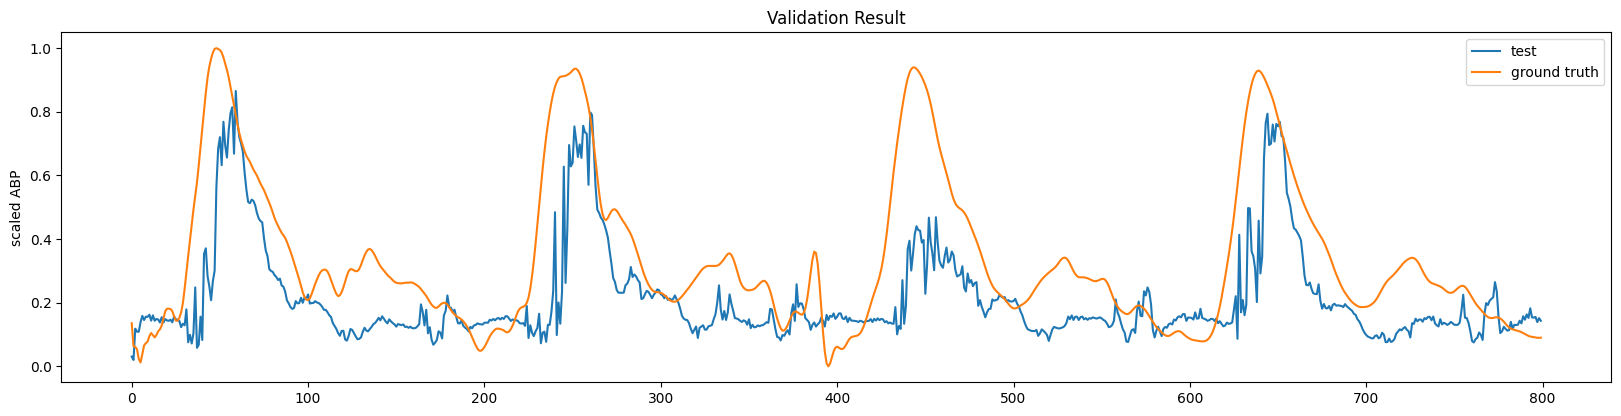

In [20]:
plt.figure(figsize=(20,10))
plt.subplot(2, 1, 1)
plt.plot(output_testset_1d[:800], label='test')
plt.title('Validation Result')
plt.ylabel('scaled ABP')
plt.plot(decoder_output_test_1d[:800], label='ground truth')
plt.legend()

In [21]:
ecg = df['II(mV)'].to_numpy()

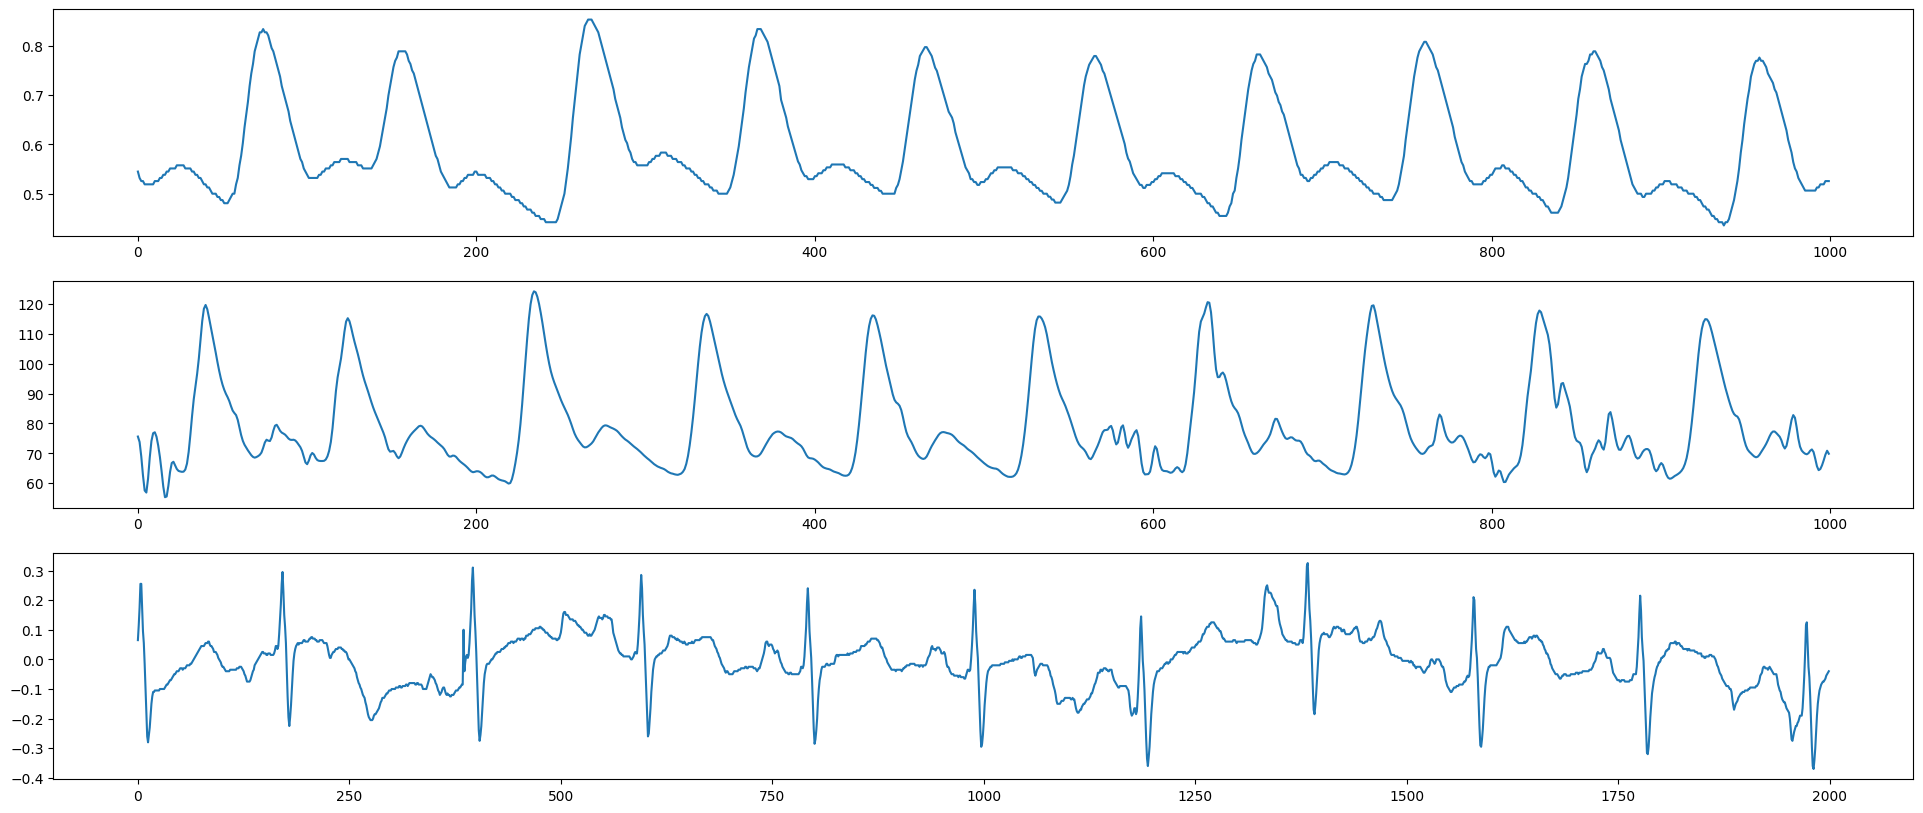

In [22]:
#set the plot bigger
plt.rcParams['figure.figsize'] = [24, 10]
plt.subplot(3,1,1)
plt.plot(pleth[4000:5000])
plt.subplot(3,1,2)
plt.plot(abp[4000:5000])
plt.subplot(3,1,3)
plt.plot(ecg[8000:10000])

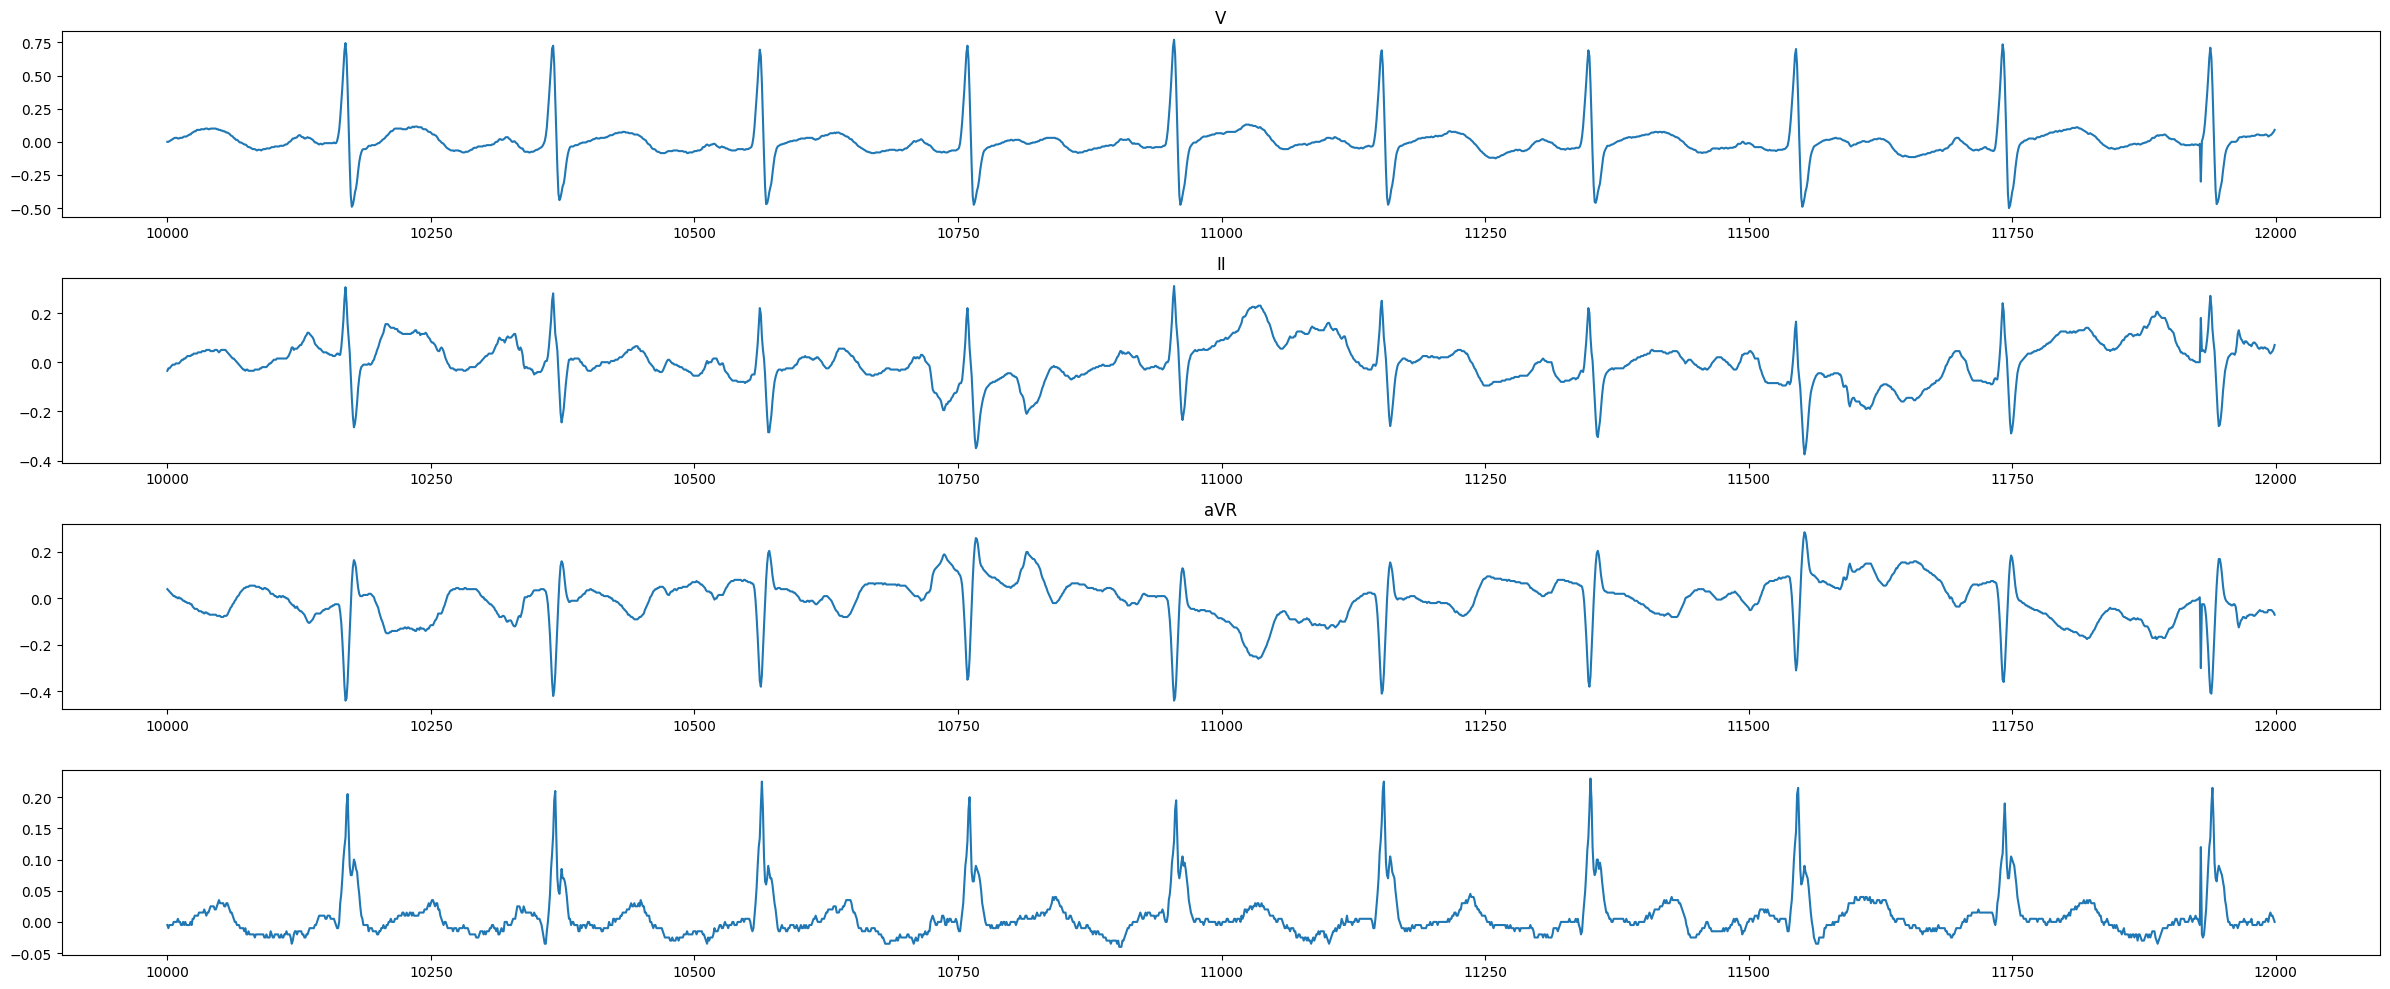

In [23]:
#plot the three columns in df
#tight layout

plt.rcParams['figure.figsize'] = [24, 10]
plt.subplot(4,1,1)
plt.plot(df['V(mV)'][10000:12000])
plt.title('V')
plt.subplot(4,1,2)
plt.plot(df['II(mV)'][10000:12000])
plt.title('II')
plt.subplot(4,1,3)

plt.plot(df['aVR(mV)'][10000:12000])
plt.title('aVR')
plt.subplot(4,1,4)

plt.plot(df['sum'][10000:12000])

plt.tight_layout()


In [24]:
torch.save(model.state_dict(), './models/model_1.pt')